## Data Cleaning & Dataframe Prep

This notebook handles the following tasks and prepares the data for the analysis.
If you something off, please fix it and add it to here.

Data Cleaning

- Delete NaN entries.
- Assign 0: Not Applicable to the Empirical Novelty that has been chosen as "Not Applicaple". We have observed that this occurs when reviewers think empirical novelty is not applicaple to a paper, which can be a theoretical one for instance. When calculating the mean of this, please do not include 0 entries.
- Ethics Flags include data which says both NO. and Yes, ... All of the contradictory entries included explanations, so we have accepted them as Yes.
- Delete reviews submitted after the deadline

Data Preparation

- Statistics related to each reviewer is calculated for each paper.
- These statics are: std, mean, diff(max_score-min_score)

### Resulting datasets

- review_df_clean -> reviewer per row cleaned data
- paper_df -> per paper dataframe, statistics are calculated such as mean, std, variance, max_min difference etc.
- df -> basic dataset

In [2]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [3]:
df.columns = df.columns.str.replace("recommendation", "score", regex=False)

### Dataframe 1: Reviewers as rows

In [4]:
# Instead of one row per paper, arrange data to have one reviewer per row.

reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]


df['paper_id'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_score', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_id']
        review_df.loc[len(review_df)] = dict_

df.head()

score
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_id
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,"3: reject, not good enough","4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reject,1
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5: marginally below the acceptance threshold,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,1. The proposed method seems tricky and not el...,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,1: The contributions are neither significant n...,NO.,2254.0,2022-10-27 20:14:54,2022-10-27 20:14:54,Reject,2
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,"8: accept, good paper","4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Overall I think the paper introduces very stro...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,Not applicable,NO.,5316.0,2022-10-27 22:09:32,2022-10-27 22:09:32,Accept: notable-top-5%,3
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,"3: reject, not good enough","4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,The paper solves an important problem. The exp...,4: All of the claims and statements are well-s...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,NO.,2937.0,2022-10-29 20:23:57,2022-10-29 20:23:57,Reject,4


### Data prep: convert and simplify column values 

1. Convert cdate to pandas datetime datatype.
2. Add time_to_deadline column which measures the time difference between the review submission and review deadline
3. To get the score part, remove the explanations from score columns such as recommendation.
3.5. If there are non-scored reviewers, assign them the avg score of the others
4. Add a is_high_variance column to detect high discrepancy reviews.
5. There are different acceptances, like top-5-notable etc. We just treat them as expected, so simply those explanations.

In [5]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], how='all', inplace=True)

def get_scores_from_str(x):
    if isinstance(x, str):
        return int(x.split(':')[0])
    else:
        return np.nan
    
df['reviewer1_score'] = df['reviewer1_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer2_score'] = df['reviewer2_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer3_score'] = df['reviewer3_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer4_score'] = df['reviewer4_score'].apply(lambda x: get_scores_from_str(x))

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

Play with variables and check if the values are as expected:

In [6]:
pd.set_option('display.max_rows', 10)
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_id,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
9,Improved Training of Physics-Informed Neural N...,Physics-informed neural networks; electrical i...,NaN,Physics-informed neural networks (PINNs) are a...,2022-09-22 14:42:07,2023-02-26 07:06:29,10,"4: You are confident in your assessment, but n...",The manuscript is using PINN to solve the prob...,This is an excellent paper. Introduction of th...,...,Accept,9,11 days 06:07:04,11 days 02:14:29,5 days 19:18:52,NaT,10.0,6.0,4.0,True
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,...,Accept,32,11 days 07:56:58,10 days 08:47:26,8 days 00:55:32,2 days 05:53:11,8.0,3.0,5.0,True
33,CircNet: Meshing 3D Point Clouds with Circumce...,Meshing; 3D Point Cloud; Point Cloud Triangula...,We present a deep neural architecture that det...,Reconstructing 3D point clouds into triangle m...,2022-09-22 14:34:26,2024-11-25 10:14:38,8,"4: You are confident in your assessment, but n...",This paper tackles the problem of point cloud ...,Strength\n+ The formulation of the problem as ...,...,Accept,33,15 days 11:46:51,13 days 09:18:49,0 days 01:53:56,-2 days +00:26:53,8.0,3.0,5.0,True
34,Semi-supervised learning with a principled lik...,Bayesian deep learning; Bayesian neural networ...,"We develop Bayesian semi-supervised learning, ...",We currently do not have an understanding of s...,2022-09-22 14:34:48,2023-02-21 09:35:10,5,"4: You are confident in your assessment, but n...",The authors consider the fact that our common ...,## Strengths\nThe paper is well argued for and...,...,Accept,34,16 days 15:04:34,10 days 04:45:05,10 days 01:48:15,7 days 20:28:22,8.0,3.0,5.0,True
37,Is Adversarial Training Really a Silver Bullet...,Data poisoning; adversarial training; indiscri...,We propose an indiscriminative feature-based p...,Indiscriminate data poisoning can decrease the...,2022-09-22 14:36:10,2023-03-02 17:30:28,6,"4: You are confident in your assessment, but n...",In this work the authors attack in models in t...,Strengths:\n* The method is novel and obtains ...,...,Accept,37,11 days 15:48:46,11 days 07:24:56,10 days 03:36:11,7 days 22:02:29,10.0,6.0,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,DDM$^2$: Self-Supervised Diffusion MRI Denoisi...,Unsupervised MRI Denoising; Diffusion Models,NaN,Magnetic resonance imaging (MRI) is a common a...,2022-09-22 14:31:21,2024-11-25 10:16:17,1,5: You are absolutely certain about your asses...,The paper proposes a new method for denoising ...,Strengths\n\nThe proposed method makes use of ...,...,Accept,3678,10 days 21:33:32,10 days 13:51:50,3 days 20:27:53,3 days 11:06:24,8.0,1.0,7.0,True
3743,SeaFormer: Squeeze-enhanced Axial Transformer ...,NaN,NaN,"Since the introduction of Vision Transformers,...",2022-09-22 14:32:03,2024-11-25 10:15:52,8,"2: You are willing to defend your assessment, ...",this paper presents SeaFormer: a new transform...,Strength:\n- The proposed transformer is O(WH)...,...,Accept,3743,11 days 16:43:04,11 days 10:33:00,10 days 21:16:35,10 days 13:05:09,8.0,3.0,5.0,True
3746,Neural Image-based Avatars: Generalizable Radi...,Generalizable human radiance fields; Human per...,NaN,We present a method that enables synthesizing ...,2022-09-22 14:41:21,2024-11-25 10:11:30,8,3: You are fairly confident in your assessment...,The authors propose Neural Image-based Avatars...,Main St

In [7]:
df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']]

,reviewer1_score,reviewer2_score,reviewer3_score,reviewer4_score
0,6,8,6.0,6.0
1,3,8,6.0,NaN
2,5,6,3.0,3.0
3,8,8,8.0,8.0
4,3,3,3.0,6.0
...,...,...,...,...
3791,3,3,5.0,NaN
3792,1,6,6.0,3.0
3793,6,6,8.0,6.0
3794,6,3,3.0,3.0


### Data Cleaning

1. Clean reviews submitted after the deadline

In [8]:
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/3064297660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


2. Treat contradictiory ethis flags as Yes, because all of them include explanation.

In [9]:
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/2241807063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


3. Assign 0 to Not applicaple papers for Empirical Novelty and Significance. These are generally treated as theoretical papers by the reviewers.

In [10]:
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

review_df_clean.reset_index(drop=True, inplace=True)

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/2876056155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


4. Add time_to_deadline column

In [11]:
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/2658128959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


5. Convert string numbers to integers.

In [12]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_score'] = review_df_clean['reviewer_score'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_score'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/3490803434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/3490803434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/3490803434.py:4: SettingW

6. Make all decisions have only "Accept"
7. Add high_variance information by joining on paper_id

In [13]:
review_df_clean['decision'] = review_df_clean['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")
review_df_clean = pd.merge(review_df_clean, df[['paper_id', 'is_high_variance']], on='paper_id', how='right')

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_76104/1487152142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['decision'] = review_df_clean['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")


## Reviewer Dataset is completed

### Dataframe 2: Papers as rows and reviewer statistics per paper

Use aggregation functions to calculate statistics per paper.
- If you want to add a statistic or change one, add it to the lists next to the column names.

In [14]:
paper_df = review_df_clean.groupby('paper_id').agg({'time_to_deadline': ['std', 'mean'], 
                                                    'review_confidence': ['std', 'mean'],
                                                    'review_score': ['std', 'mean', 'max', 'min'],
                                                    'review_correctness': ['std', 'mean'],
                                                    'review_technical_novelty_and_significance': ['std', 'mean'],
                                                    'review_empirical_novelty_and_significance': ['std', 'mean'],
                                                    'reviewer': 'count',
                                                    'decision': 'first'}).reset_index()

paper_df["reviewer1_score"] = df["reviewer1_score"] 
paper_df["reviewer2_score"] = df["reviewer2_score"] 
paper_df["reviewer3_score"] = df["reviewer3_score"] 
paper_df["reviewer4_score"] = df["reviewer4_score"]

In [15]:
pd.set_option('display.max_columns', None)
paper_df

paper_id          time_to_deadline                             \
                                    std                       mean   
0           0 5 days 19:16:10.689828726            9 days 14:20:49   
1           1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2           2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3           3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4           4 5 days 09:23:30.024963235    12 days 02:20:32.750000   
...       ...                       ...                        ...   
3791     3791 5 days 23:13:08.435799653 16 days 11:16:41.666666666   
3792     3792 4 days 09:28:45.175281084    11 days 22:56:18.250000   
3793     3793 1 days 20:41:21.379731310    11 days 20:54:33.750000   
3794     3794 3 days 09:33:53.422118322     8 days 04:57:49.750000   
3795     3795 7 days 04:45:12.891550738           11 days 06:42:36   

     review_confidence           review_score                    \
                   std      mean          std      mean max min   
0             0.577350  3.500000     1.000000  6.500000   8   6   
1             0.577350  3.666667     2.516611  5.666667   8   3   
2             0.500000  4.750000     1.500000  4.250000   6   3   
3             0.500000  3.250000     0.000000  8.000000   8   8   
4             0.500000  3.750000     1.500000  3.750000   6   3   
...                ...       ...          ...       ...  ..  ..   
3791          0.000000  4.000000     1.154701  3.666667   5   3   
3792          0.816497  3.000000     2.449490  4.000000   6   1   
3793          0.577350  3.500000     1.000000  6.500000   8   6   
3794          0.000000  4.000000     1.500000  3.750000   6   3   
3795          0.000000  4.000000     0.577350  5.666667   6   5   

     review_correctness           review_technical_novelty_and_significance  \
                    std      mean                                       std   
0              1.000000  3.500000                                  0.000000   
1              1.154701  3.333333                                  1.000000   
2              0.500000  2.750000                                  0.816497   
3              0.577350  3.500000                                  0.577350   
4              0.577350  3.500000                                  0.000000   
...                 ...       ...                                       ...   
3791           0.577350  3.333333                                  0.577350   
3792           1.290994  2.500000                                  0.500000   
3793           0.577350  3.500000                                  0.500000   
3794           0.816497  3.000000                                  0.577350   
3795           0.577350  2.666667                                  0.577350   

               review_empirical_novelty_and_significance           reviewer  \
          mean                                       std      mean    count   
0     3.000000                                  0.500000  2.250000        4   
1     3.000000                                  0.577350  2.333333        3   
2     2.000000                                  0.577350  1.500000        4   
3     3.500000                                  2.309401  2.000000        4   
4     2.000000                                  1.000000  1.500000        4   
...        ...                                       ...       ...      ...   
3791  2.666667                                  1.154701  0.666667        3   
3792  2.750000                                  1.000000  0.500000        4   
3793  2.250000                                  1.414214  2.000000        4   
3794  2.500000                                  0.577350  2.500000        4   
3795  2.666667                                  0.577350  2.666667        3   

     decision reviewer1_score reviewer2_score reviewer3_score reviewer4_score  
        first                                                                  
0     

Add max-min difference column. This is our most basic metric for measuring discrepancy.

In [16]:
paper_df['review_score', 'max_min_diff'] = paper_df['review_score', 'max'] - paper_df['review_score', 'min']

Add high discrepancy papers.

In [17]:
paper_df['is_high_discrepancy'] = (paper_df['review_score', 'max_min_diff'] >= 4).astype(int)

## Paper Dataset is completed

In [18]:
print("See the portion of papers accepted and rejected and has high discrepancy.")
print(paper_df.groupby(('decision', 'first'))['is_high_discrepancy'].mean())

See the portion of papers accepted and rejected and has high discrepancy.
(decision, first)
Accept    0.125238
Reject    0.182636
Name: is_high_discrepancy, dtype: float64


# Review Submission Time vs. Discrepancy Analysis

In [19]:
def custom_idx_min_time(row: pd.Series):
    min_val = row[['reviewer1_time_to_deadline', 'reviewer2_time_to_deadline', 'reviewer3_time_to_deadline', 'reviewer4_time_to_deadline']].min()
    min_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_time_to_deadline'] == min_val:
            min_val_str += str(i)

    return min_val_str

def custom_idx_min_rec(row: pd.Series):
    min_val = row[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min()
    min_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_score'] == min_val:
            min_val_str += str(i)

    return min_val_str

def custom_idx_max(row: pd.Series):
    max_val = row[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max()
    max_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_score'] == max_val:
            max_val_str += str(i)

    return max_val_str

In [20]:
pd.set_option('display.max_rows', 200)

# df['min_time_to_deadline_index'] = df.apply(lambda x: custom_idx_min_time(x), axis=1)
df['min_score_index'] = df.apply(lambda x: custom_idx_min_rec(x), axis=1)
df['max_score_index'] = df.apply(lambda x: custom_idx_max(x), axis=1)

Things to note:
- submission time of the reviewer 1 < 2 < 3 < 4, so the latest submitter is always reviewer 4.

Experiment 1: we checked whether the latest submitter is giving the lowest grades (which can cause discrepancy among high variance accepted papers). We have checked who gave the lowest grade here, because among the accepted papers the discrepancy creator is generally the reviewer who gave a really low score (since paper needs to get higher scores from others to get accepted).

We have seen that the distribution is not showing us any bias among the lowest grade givers based on the submission time.

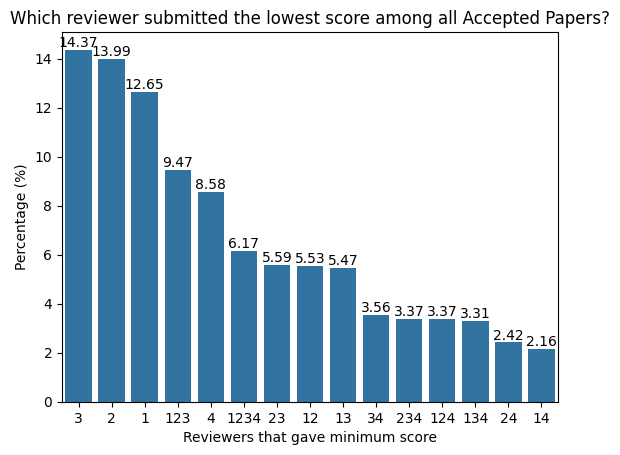

In [21]:
pd_series = (100 * df[df['decision'].eq("Accept")]['min_score_index'].value_counts(normalize=True)).round(2)
accepted_partition_into_reviewers = pd_series.to_list()
x_names = list(pd_series.index.values)

ax = sns.barplot(x=x_names, y=accepted_partition_into_reviewers)
ax.bar_label(ax.containers[0])
plt.title("Which reviewer submitted the lowest score among all Accepted Papers?")
plt.xlabel('Reviewers that gave minimum score')
plt.ylabel('Percentage (%)')
plt.show()

Experiment 2: We checked if among accepted high discrepancy papers which reviewer submittion what portion of the lowest scores? 

We have observed that there is still not a strong relationship between the submission time and giving the lowest score.

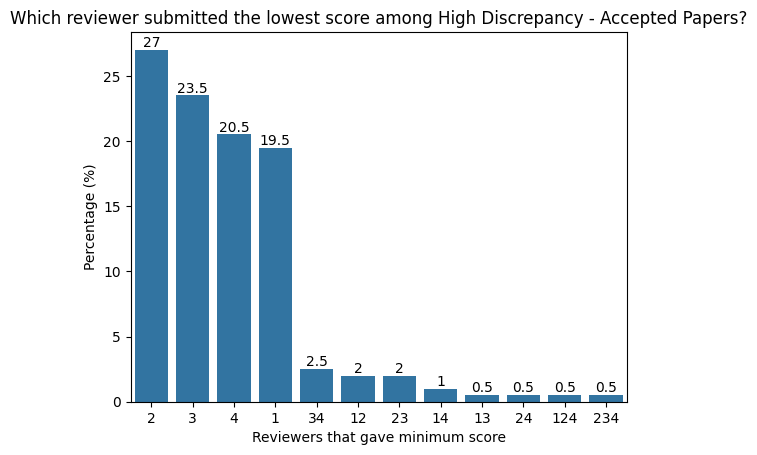

In [22]:
pd_series = (100 * df[df['decision'].eq("Accept") & df["is_high_variance"].eq(1)]['min_score_index'].value_counts(normalize=True)).round(2)
accepted_partition_into_high_var_reviewers = pd_series.to_list()
x_names = list(pd_series.index.values)

ax = sns.barplot(x=x_names, y=accepted_partition_into_high_var_reviewers)
ax.bar_label(ax.containers[0])
plt.title("Which reviewer submitted the lowest score among High Discrepancy - Accepted Papers?")
plt.xlabel('Reviewers that gave minimum score')
plt.ylabel('Percentage (%)')
plt.show()

Experiment 3: We checked if among rejected high discrepancy papers which reviewer submittion what portion of the maximum scores? 

4 olma garantisi gerek veya sonuncu birinci vs. hesabı yapmam lazım

In [23]:
df.head()

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,reviewer1_clarity_quality_novelty_and_reproducibility,reviewer1_summary_of_the_review,reviewer1_correctness,reviewer1_technical_novelty_and_significance,reviewer1_empirical_novelty_and_significance,reviewer1_flag_for_ethics_review,reviewer1_length,reviewer1_cdate,reviewer1_tmdate,reviewer2_score,reviewer2_confidence,reviewer2_summary_of_the_paper,reviewer2_strength_and_weaknesses,reviewer2_clarity_quality_novelty_and_reproducibility,reviewer2_summary_of_the_review,reviewer2_correctness,reviewer2_technical_novelty_and_significance,reviewer2_empirical_novelty_and_significance,reviewer2_flag_for_ethics_review,reviewer2_length,reviewer2_cdate,reviewer2_tmdate,reviewer3_score,reviewer3_confidence,reviewer3_summary_of_the_paper,reviewer3_strength_and_weaknesses,reviewer3_clarity_quality_novelty_and_reproducibility,reviewer3_summary_of_the_review,reviewer3_correctness,reviewer3_technical_novelty_and_significance,reviewer3_empirical_novelty_and_significance,reviewer3_flag_for_ethics_review,reviewer3_length,reviewer3_cdate,reviewer3_tmdate,reviewer4_score,reviewer4_confidence,reviewer4_summary_of_the_paper,reviewer4_strength_and_weaknesses,reviewer4_clarity_quality_novelty_and_reproducibility,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_id,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance,min_score_index,max_score_index
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,### Clarity\nThis paper is mostly well-written...,"Though this paper presents a new, promising me...",2: Several of the paper’s claims are incorrect...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3055,2022-10-20 09:40:48,2022-11-23 10:36:28,8,3: You are fairly confident in your assessment...,This paper adapts ideas from formal program an...,# Strengths\n\nThe technique is well motivated...,The technique and motivation are clearly commu...,The paper contributes a novel algorithm for cr...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,NO.,3272,2022-10-25 00:42:31,2022-10-25 00:42:31,6.0,3: You are fairly confident in your assessment...,The paper proposes a method for safe reinforce...,+ The approach reduces the number of safety vi...,The paper is overall well written and presente...,The paper builds on previous work on safe rein...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,1508.0,2022-10-26 00:04:46,2022-10-26 00:04:46,6.0,"4: You are confident in your assessment, but n...","The paper proposes a safe RL algorithm, Symbol...",Strengths:\n* SPICE’s use of formal methods pr...,The paper is generally clear. I appreciate the...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept,0,15 days 15:19:12,11 days 00:17:29,10 days 00:55:14,1 days 16:51:21,8.0,6.0,2.0,False,134,2
1,An Adaptive Entropy-Regularization Framework

In [42]:
df[["reviewer1_score", "reviewer2_score", "reviewer3_score", "reviewer4_score"]]
df["num_valid_reviews"] = df[["reviewer1_score", "reviewer2_score", "reviewer3_score", "reviewer4_score"]].apply(lambda x: 4 - x.isnull().sum(), axis=1)
df["last_reviewer_score"] = df.apply(lambda x: x[f"reviewer{x['num_valid_reviews']}_score"], axis=1)

df["is_first_higher"] = df.apply(lambda x: x["reviewer1_score"] > x["last_reviewer_score"], axis=1)
print(df["is_first_higher"].value_counts())
print(df["num_valid_reviews"].value_counts())

is_first_higher
False    2633
True     1163
Name: count, dtype: int64
num_valid_reviews
4    2628
3    1166
2       2
Name: count, dtype: int64


In [38]:
pd_series = (100 * df[df['decision'].eq("Reject") & df["is_high_variance"].eq(1)]['is_first_higher'].value_counts(normalize=True))
pd_series

is_first_higher
False    61.165049
True     38.834951
Name: proportion, dtype: float64

In [ ]:
pd_series = (100 * df[df['decision'].eq("Reject") & df["is_high_variance"].eq(1)]['max_score_index'].value_counts(normalize=True)).round(2)
accepted_partition_into_high_var_reviewers = pd_series.to_list()
x_names = list(pd_series.index.values)

ax = sns.barplot(x=x_names, y=accepted_partition_into_high_var_reviewers)
ax.bar_label(ax.containers[0])
plt.title("Which reviewer submitted the highest score among High Discrepancy - Rejected Papers?")
plt.xlabel('Reviewers that gave maximum score')
plt.ylabel('Percentage (%)')
plt.show()

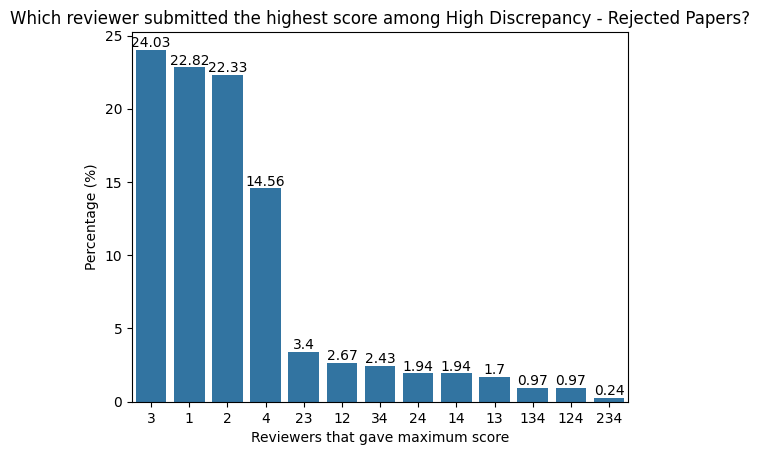

In [24]:
pd_series = (100 * df[df['decision'].eq("Reject") & df["is_high_variance"].eq(1)]['max_score_index'].value_counts(normalize=True)).round(2)
accepted_partition_into_high_var_reviewers = pd_series.to_list()
x_names = list(pd_series.index.values)

ax = sns.barplot(x=x_names, y=accepted_partition_into_high_var_reviewers)
ax.bar_label(ax.containers[0])
plt.title("Which reviewer submitted the highest score among High Discrepancy - Rejected Papers?")
plt.xlabel('Reviewers that gave maximum score')
plt.ylabel('Percentage (%)')
plt.show()

Experiment 4: What portion of the late submissions belong to high variance papers?

We have observed that the portion of high variance papers among the reviews submittion (0.5, 1, 3 and 10 days) before the deadline does not change. Thus, there is no relationship between being a late submitter and creating discrepancy by giving a score that is far from the consensus.

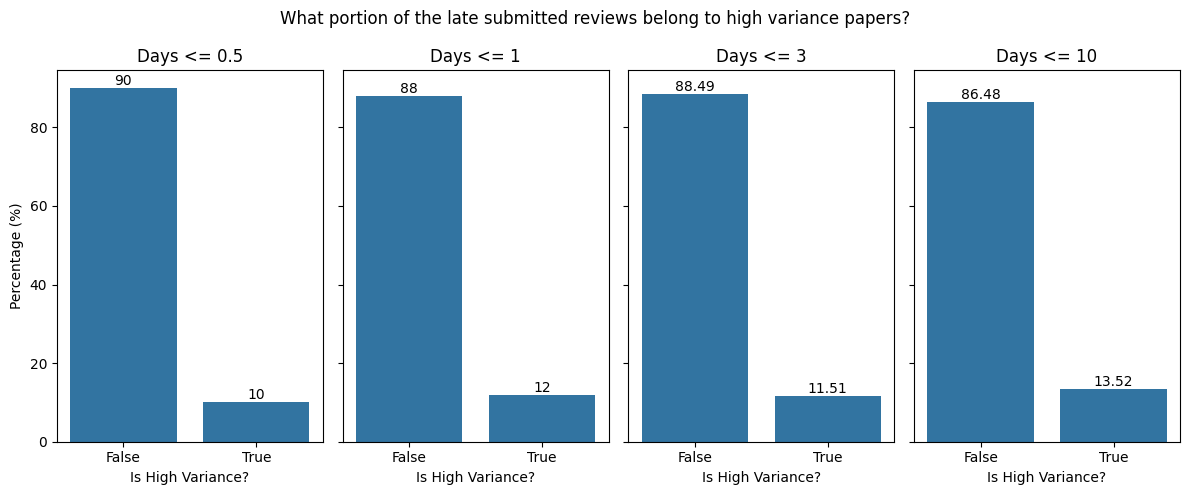

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
days_list = [0.5, 1, 3, 10]

for i, days in enumerate(days_list):
    pd_series = (100 * review_df_clean[review_df_clean['decision'].eq("Accept") & 
                                review_df_clean["time_to_deadline"].le(pd.Timedelta(days=days))]['is_high_variance']
                 .value_counts(normalize=True)).round(2)
    
    accepted_partition_into_high_var_reviewers = pd_series.to_list()
    x_names = list(pd_series.index.values)

    ax = sns.barplot(x=x_names, y=accepted_partition_into_high_var_reviewers, ax=axes[i])
    ax.bar_label(ax.containers[0])
    ax.set_title(f"Days <= {days}")
    ax.set_xlabel('Is High Variance?')
    ax.set_ylabel('Percentage (%)' if i == 0 else "")

plt.suptitle("What portion of the late submitted reviews belong to high variance papers?")
plt.tight_layout()
plt.show()

In [26]:
(100 * df[df['decision'].eq("Accept")]['max_score_index'].value_counts(normalize=True)).round(2)


max_score_index
1       13.03
3       12.27
2       11.38
123      9.66
4        7.50
12       7.37
13       6.68
23       6.23
1234     6.17
14       3.94
124      3.56
24       3.18
34       3.18
234      3.12
134      2.73
Name: proportion, dtype: float64

In [41]:
print(review_df_clean.columns)
print(paper_df.columns)

Index(['paper_id', 'reviewer', 'reviewer_summary_of_the_paper',
       'reviewer_strength_and_weaknesses',
       'reviewer_clarity_quality_novelty_and_reproducibility',
       'reviewer_summary_of_the_review', 'reviewer_flag_for_ethics_review',
       'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title',
       'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision',
       'time_to_deadline', 'review_confidence', 'review_score',
       'review_correctness', 'review_technical_novelty_and_significance',
       'review_empirical_novelty_and_significance', 'is_high_variance'],
      dtype='object')
MultiIndex([(                                 'paper_id',             ''),
            (                         'time_to_deadline',          'std'),
            (                         'time_to_deadline',         'mean'),
            (                        'review_confidence',          'std'),
            (                        'review_confidence',         'mean'),
   